In [88]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft
from scipy import signal
from numpy.fft import fft
import librosa, librosa.display
# from numba import jit

# Prova de conceito p/ TCC
### Reprodução do Modulation Toolbox, de Pascal Clark, University of Washington EE Department (2010)
### Reimplementação em Python
### Miguel de Sousa, Universidade Federal do Rio de Janeiro, Abril/2021

Consider the following synthetic test signal consisting of a low-frequency modulator multiplied by a linear chirp (starting at 800 Hz and increasing at 100Hz/sec.

In [89]:
fs = 8000
# N = 2 * 4*fs
N = 4*fs
modFreq = 2
carrFreq = 800
t = np.arange(N) / fs

print(f"t goes from {t[0]} to {t[-1]}")

t goes from 0.0 to 3.999875


In [90]:
from librosa import stft
from numpy import conjugate, zeros_like

def plot_signal(signal, t, F_coef, x_view_max_t, x_view_max_fft, suptitle, letter, x_view_min_fft=0):
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.title(f'${letter}[t]$')
    plt.xlabel('t (seconds)')
    plt.axis(xmin=0, xmax=x_view_max_t)
    plt.plot(t, signal)
    plt.subplot(1, 2, 2)
    plt.title(f'$|{letter.upper()}[k]|$')
    plt.xlabel('$F_{coef}$ $[k]$')
    plt.plot(F_coef, abs(fft(signal)))
    plt.axis(xmin=x_view_min_fft, xmax=x_view_max_fft)
    plt.suptitle(suptitle)
    
def plot_stft(signal, fs, title, max_y_index = None):
    D = librosa.stft(signal)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=ax, sr = fs)
    ax.set(title=title)
    fig.colorbar(img, ax=ax, format="%+2.f dB")
    
def plot_mod_specgram(signal, fs, title):
    D, _, _ = get_mod_specgram(signal)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=ax, sr = fs)
    ax.set(title=title)
    fig.colorbar(img, ax=ax, format="%+2.f dB")
    
def stft_basic(x, w, Fs, H=8, only_positive_frequencies=False):
    """Compute a basic version of the discrete short-time Fourier transform (STFT)

    Notebook: C2/C2_STFT-Basic.ipynb

    Args:
        x (np.ndarray): Signal to be transformed
        w (np.ndarray): Window function
        H (int): Hopsize (Default value = 8)
        only_positive_frequencies (bool): Return only positive frequency part of spectrum (non-invertible)
            (Default value = False)

    Returns:
        X (np.ndarray): The discrete short-time Fourier transform
    """
    N = len(w)
    L = len(x)
    M = np.floor((L - N) / H).astype(int) + 1
    X = np.zeros((N, M), dtype='complex')
    for m in range(M):
        x_win = x[m * H:m * H + N] * w
        X_win = np.fft.fft(x_win)
        X[:, m] = X_win

    if only_positive_frequencies:
        K = 1 + N // 2
        X = X[0:K, :]
        
    F_coef = np.arange(X.shape[0]) * Fs / N
    # print(F_coef)
    T_coef = np.arange(X.shape[1]) * H / Fs
    # print(T_coef)
    return (X, F_coef, T_coef)

def get_mod_specgram(x, w, Fs, H=8, only_positive_frequencies=False, max_mod=None) -> np.ndarray:
    """generate a modulation spectrogram, like Atlas(2003)"""
    D, _, _ = stft_basic(x, w, Fs, H)
    print(f'D.shape = {D.shape}')
    N = len(D[1])
    g = np.ones(N)
    X = np.zeros((D.shape[0], N), dtype='complex')
    print(X.shape)
    print(X.shape)
    print(f'X.shape = {X.shape}')
    for m in range(X.shape[0]):
        x_win = np.abs(D[m]) * g
        X_win = np.fft.fft(x_win)
        X[m] = X_win
    
    if only_positive_frequencies:
        K = 1 + D.shape[0] // 2
        X = X[0:K, :]
        
    if max_mod is not None:
        X = X[:, 0:max_mod]
           
    F_coef = np.arange(D.shape[0]) * Fs / len(w)
    Mod_coef = np.arange(X.shape[1]) * g / Fs   
    if only_positive_frequencies:
        V = 1 + D.shape[1] // 2
        Mod_coef = Mod_coef[0:V]
        X = X[:, 0:V]
    return (X, F_coef, Mod_coef)

def plot_content(x,t,Y,boundaries, is_mod=False):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(len(t)), x, c='k')
    plt.xlim([0, len(t)])
    plt.xlabel('Index (samples)')
    plt.subplot(1, 2, 2)
    plt.imshow(Y, origin='lower', aspect='auto', cmap='gray_r')
#     plt.imshow(Y, origin='lower', aspect='auto', cmap='gray_r',extent=boundaries)
    plt.ylabel('Index (frequency) -> Hz')
    if is_mod:
        plt.xlabel('Index (frequency) -> Hz')
        return;
    plt.xlabel('Index (frames) -> seconds')

    
def get_stft_boundaries(F_coef, T_coef, N, Fs):
    left = min(T_coef)
    right = max(T_coef) + N / Fs
    lower = min(F_coef)
    upper = max(F_coef)
    return [left, right, lower, upper]

def get_mod_boundaries(F_coef, Mod_coef, g, Fs):
    left = min(Mod_coef)
    right = max(Mod_coef) + len(g) / Fs
    lower = min(F_coef)
    upper = max(F_coef)
    return [left, right, lower, upper]

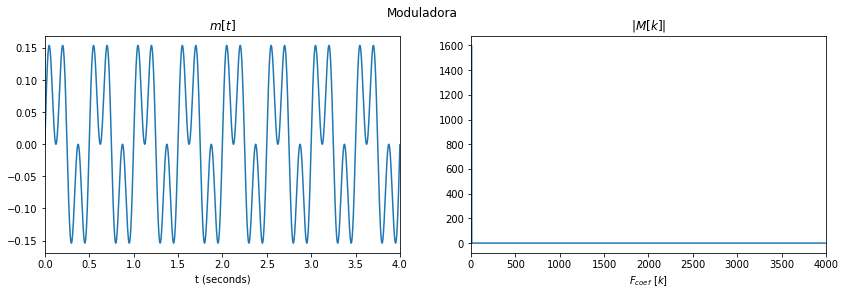

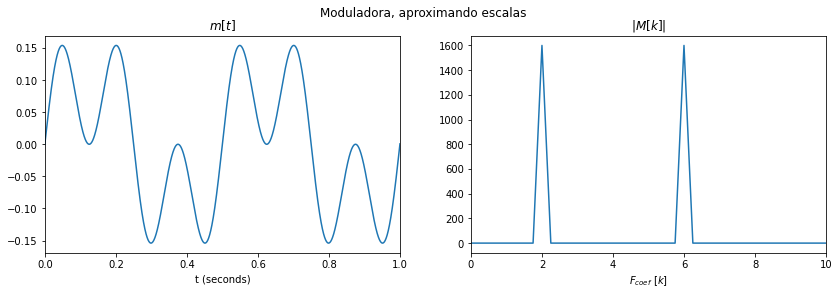

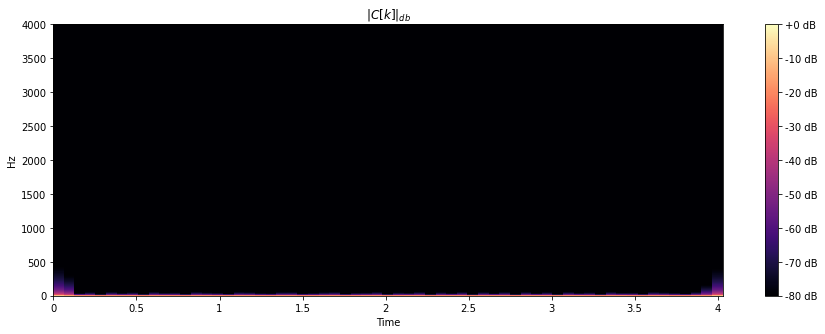

In [91]:
modulator = 0.1 * (np.sin(2*np.pi*modFreq*t) + np.sin(2*np.pi*3*modFreq*t))
modulator_fft = abs(fft(modulator))
M_coef = np.arange(modulator_fft.shape[0]) * fs / (N)
plot_signal(modulator, t, M_coef, 4, 4000, 'Moduladora', 'm')
plot_signal(modulator, t, M_coef, 1, 10, 'Moduladora, aproximando escalas', 'm')
plot_stft(modulator, fs, '$|C[k]|_{db}$')

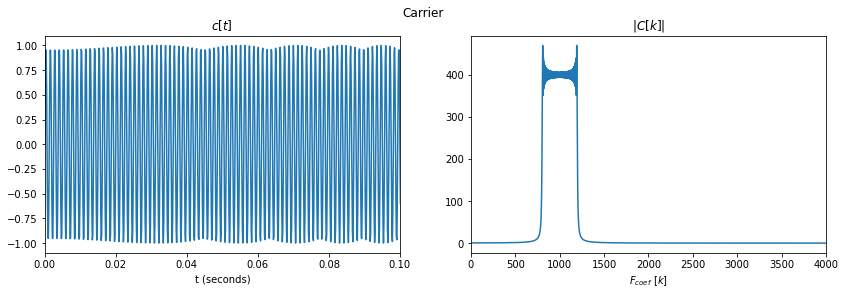

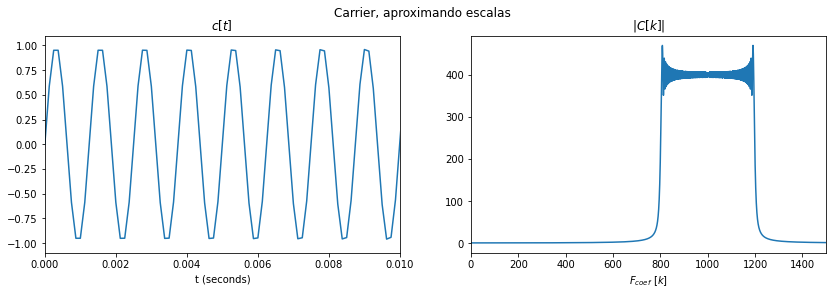

In [92]:
carrier = np.sin(2*np.pi*(carrFreq*t + 50*np.square(t)))
carrier_fft = abs(fft(carrier))
C_coef = np.arange(carrier_fft.shape[0]) * fs / (N)
plot_signal(carrier, t, C_coef, 0.1, 4000, 'Carrier', 'c')
plot_signal(carrier, t, C_coef, 0.01, 1500, 'Carrier, aproximando escalas', 'c')

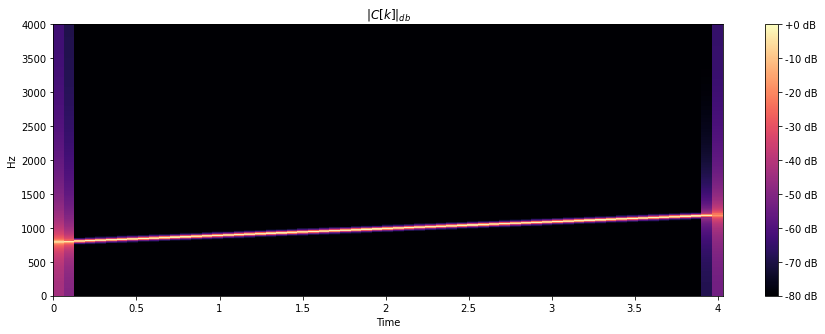

In [93]:
plot_stft(carrier, fs, '$|C[k]|_{db}$')

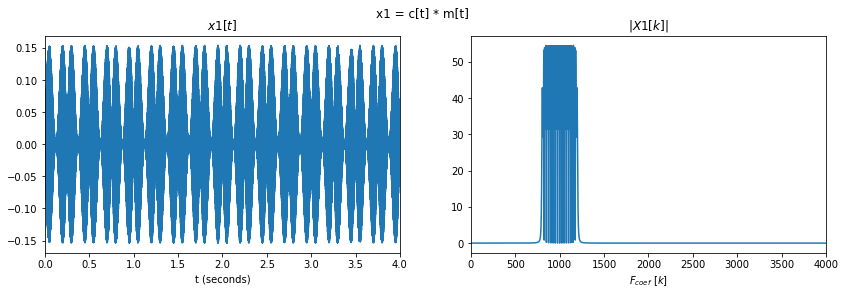

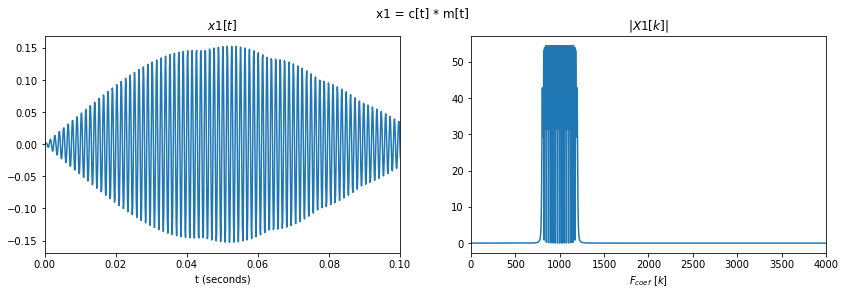

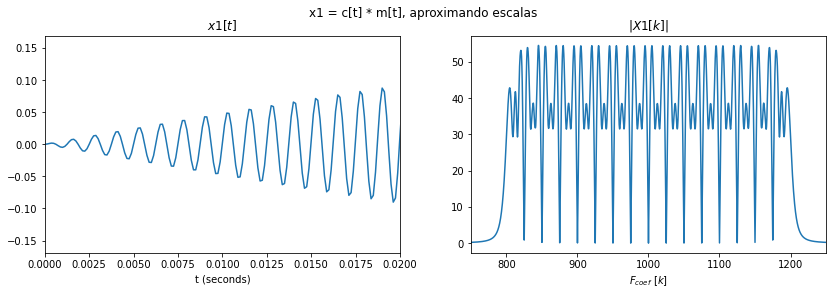

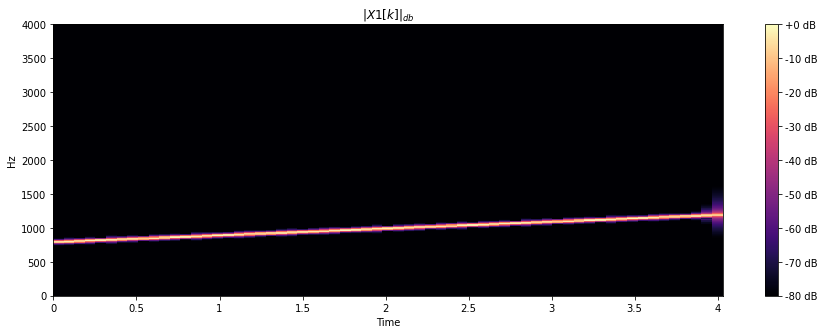

In [94]:
x1 = np.multiply(modulator, carrier)
X1 = abs(fft(x1))
X1_coef = np.arange(X1.shape[0]) * fs / (N)
plot_signal(x1, t, X1_coef, 4, 4000, 'x1 = c[t] * m[t]', 'x1')
plot_signal(x1, t, X1_coef, 0.1, 4000, 'x1 = c[t] * m[t]', 'x1')
plot_signal(x1, t, X1_coef, 0.02, 1250, 'x1 = c[t] * m[t], aproximando escalas', 'x1', x_view_min_fft=750)

plot_stft(x1, fs, '$|X1[k]|_{db}$')

# Com base na implementação do Muller

In [95]:
# old
# Eu tentei fazer um tensor, sem querer o_o
#     D_conj = conjugate(D)
#     P = zeros_like(D)
#     ETA, OMEGA = P.shape
#     max_row, max_column = D.shape
#     for column in range(0, max_column):
#         for eta in range(0, ETA):
#             for omega in range(0, OMEGA):
#                 if omega - eta / 2 > 0 and omega + eta / 2 < max_row:
#                     P[eta, omega] = P[eta, omega] + D[round(omega - eta / 2), column] * D_conj[round(omega + eta / 2), column]
#     return P

D.shape = (128, 145)
(128, 145)
(128, 145)
X.shape = (128, 145)


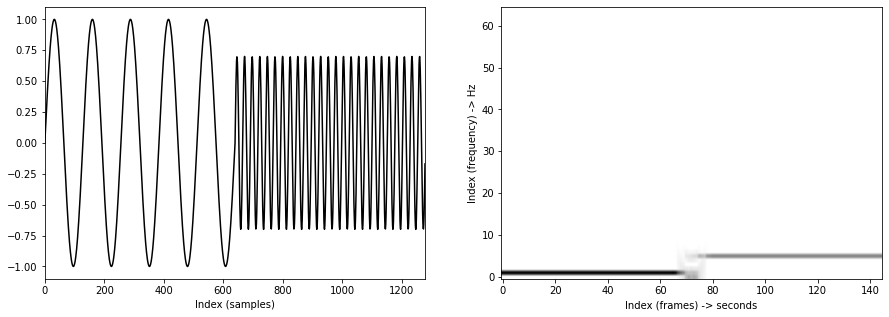

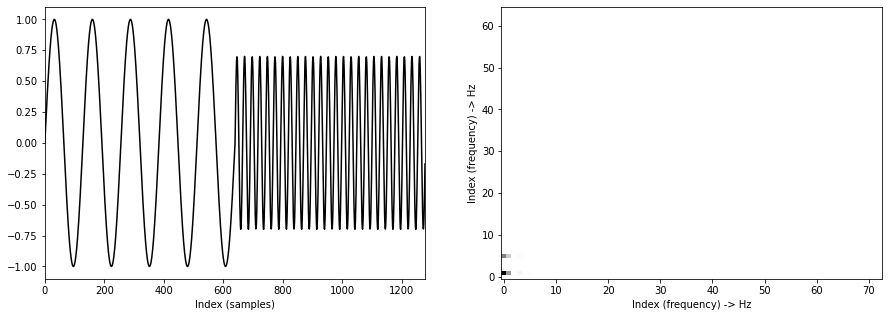

In [96]:
Fs = 128
duration = 10
omega1 = 1
omega2 = 5
N = int(duration * Fs)
t = np.arange(N) / Fs
t1 = t[:N//2]
t2 = t[N//2:]

x1 = 1.0 * np.sin(2 * np.pi * omega1 * t1)
x2 = 0.7 * np.sin(2 * np.pi * omega2 * t2)
x = np.concatenate((x1, x2))
 
H = 8
N = 128


w = np.ones(N)
X, F_coef, T_coef = stft_basic(x, w, Fs, H, only_positive_frequencies=True)
ModX, _, Mod_coef = get_mod_specgram(x, w, Fs, H, only_positive_frequencies=True)

Y = np.abs(X) ** 2
ModY = np.abs(ModX) ** 2

plot_content(x,t,Y,get_stft_boundaries(F_coef, T_coef, N, Fs))
plot_content(x,t,ModY, get_mod_boundaries(F_coef, Mod_coef, X[1], Fs), is_mod=True)

ex:
Sinal com 200 amostras.
janela de tamanho 10, sem overlap.
STFT terá resolução de 10 frames na frequência, 20 frames no tempo.

ex2:
STFT com 10 frames na frequência, 20 frames no tempo.
Para cada frequência (ou seja, cada linha da matriz), faço uma FFT com os 20 frames no tempo.

Dessa forma, a matriz terá 10 frames das frequências originais da STFT, e 20 frames de modulação de amplitude.

dispensar os frames com as frequências negativas antes de plotar nos gráficos.

t goes from 0.0 to 3.999875
D.shape = (2048, 3745)
(2048, 3745)
(2048, 3745)
X.shape = (2048, 3745)
D.shape = (2048, 3745)
(2048, 3745)
(2048, 3745)
X.shape = (2048, 3745)
D.shape = (2048, 3745)
(2048, 3745)
(2048, 3745)
X.shape = (2048, 3745)


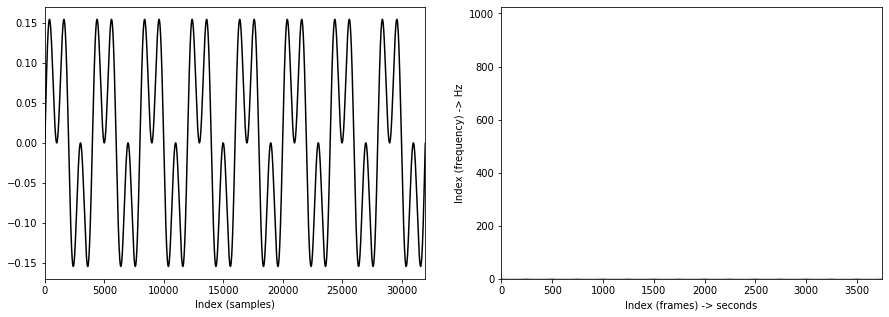

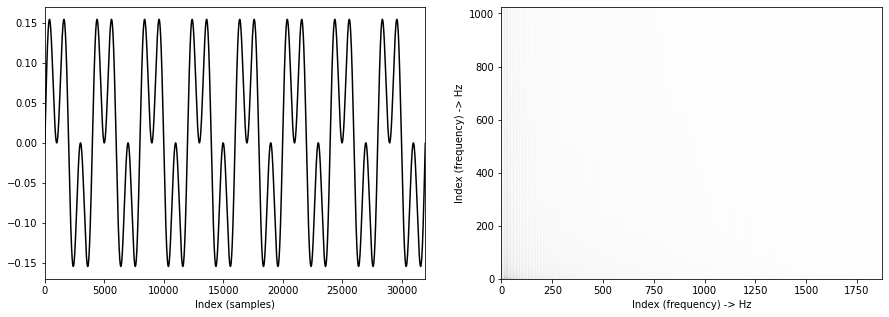

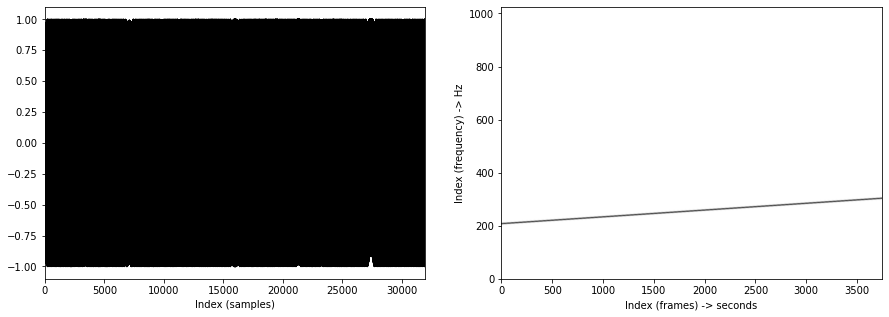

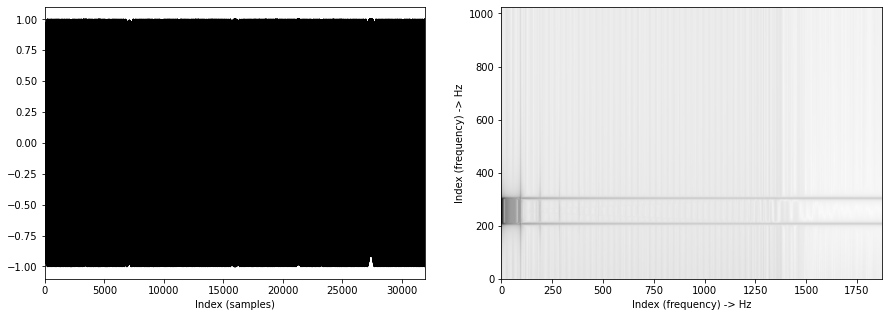

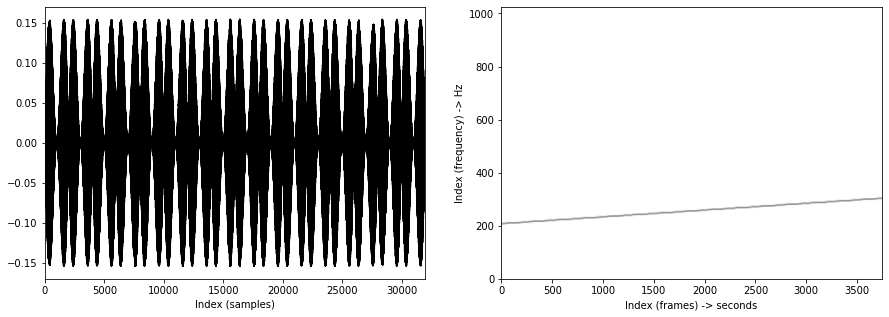

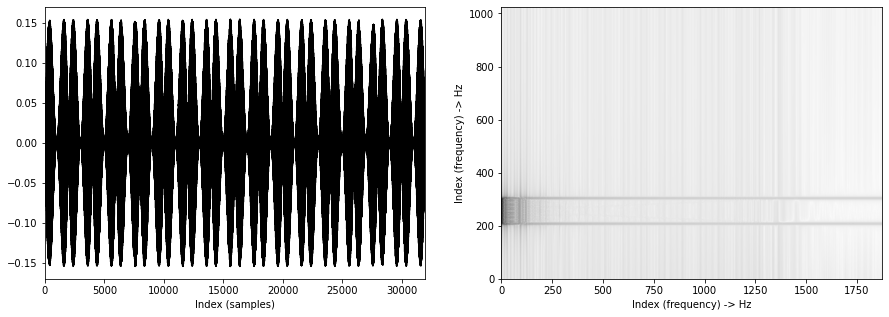

In [97]:
fs = 8000
N = 4*fs
modFreq = 2
carrFreq = 800
t = np.arange(N) / fs
print(f"t goes from {t[0]} to {t[-1]}")

modulator = 0.1 * (np.sin(2*np.pi*modFreq*t) + np.sin(2*np.pi*3*modFreq*t))
carrier = np.sin(2*np.pi*(carrFreq*t + 50*np.square(t)))
x1 = np.multiply(modulator, carrier)

H = 8
N = 2048
w = np.ones(N)

def block_plot(x,t,w,H,only_positive_frequencies=True):
    X, F_coef, T_coef = stft_basic(x, w, Fs, H, only_positive_frequencies)
    ModX, _, Mod_coef = get_mod_specgram(x, w, Fs, H, only_positive_frequencies)
    plot_content(x,t,np.abs(X) ** 2, get_stft_boundaries(F_coef, T_coef, N, Fs))
    plot_content(x,t,np.abs(ModX) ** (1. / 4), get_mod_boundaries(F_coef, Mod_coef, X[1], Fs), is_mod=True)

block_plot(modulator,t,w,H)
block_plot(carrier,t,w,H)
block_plot(x1,t,w,H)

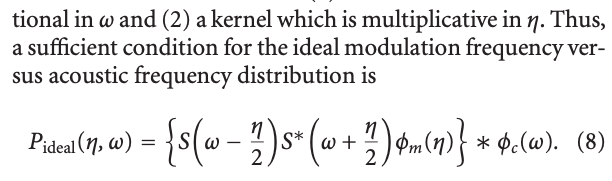

Novo teste.

t goes from 0.0 to 3.9999773242630385. It has len(176400) samples
slice_size = 29400, start = 0, end = 29400
slice_size = 29400, start = 29400, end = 58800
slice_size = 29400, start = 58800, end = 88200
slice_size = 29400, start = 88200, end = 117600
slice_size = 29400, start = 117600, end = 147000
slice_size = 29400, start = 147000, end = 176400


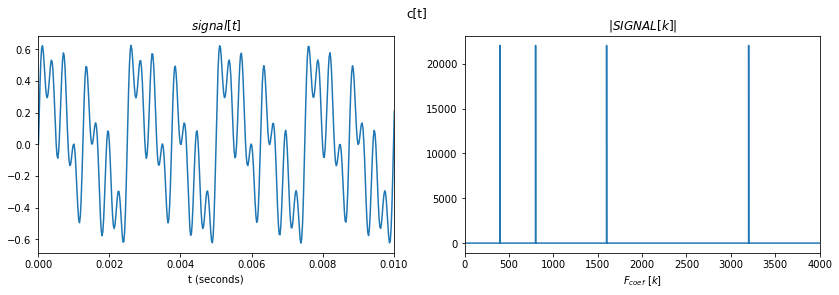

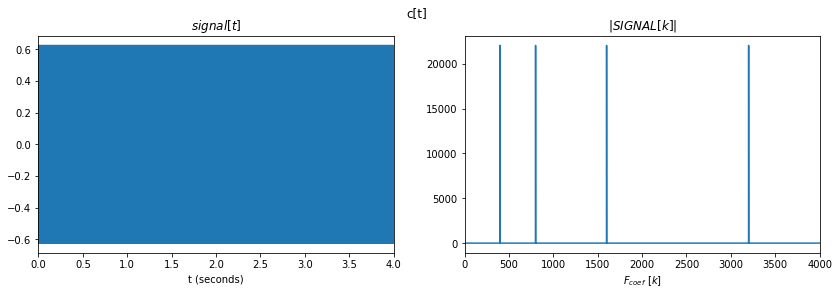

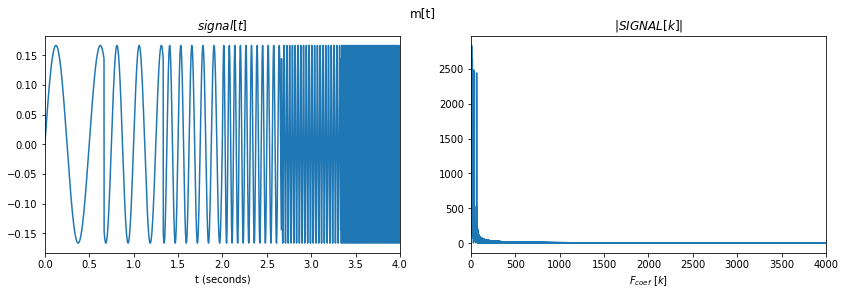

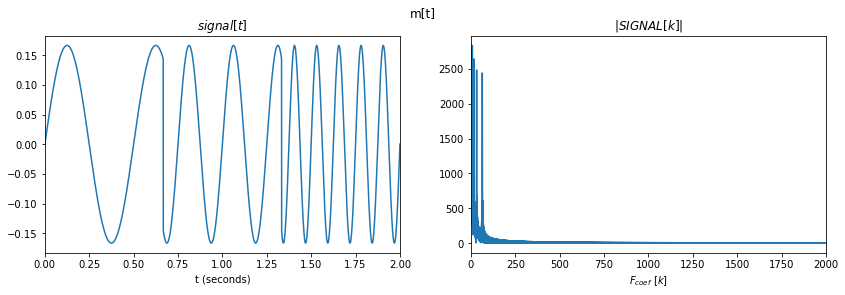

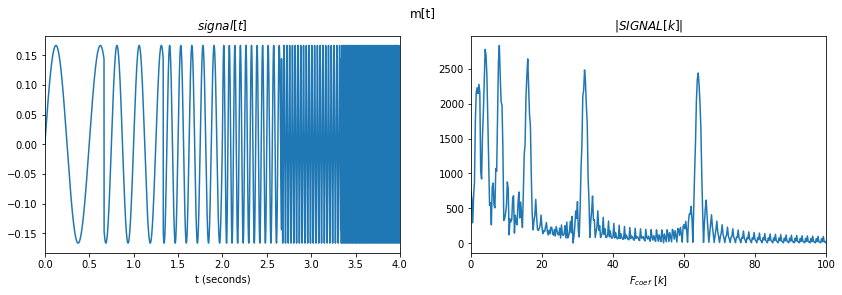

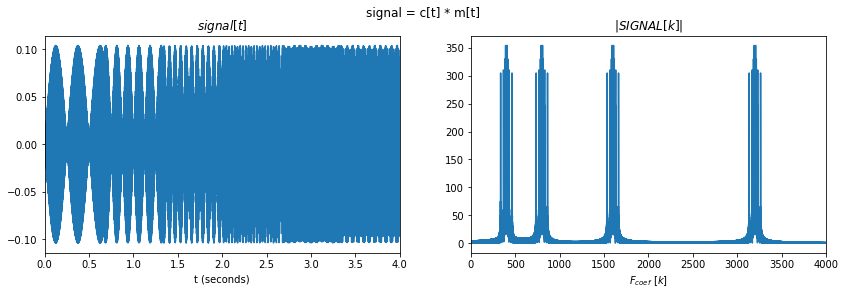

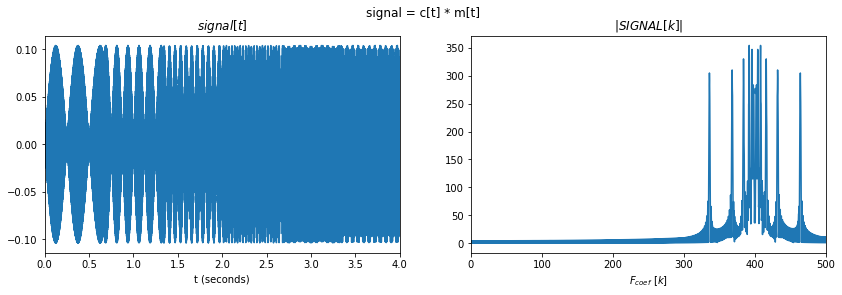

In [98]:
fs = 44100
sample_length = 4*fs
modFreq = [2, 4, 8, 16, 32, 64]
carrFreq = [400, 800, 1600, 3200]
t = np.arange(sample_length) / fs
print(f"t goes from {t[0]} to {t[-1]}. It has len({sample_length}) samples")
carrier = np.zeros(shape=(len(t)))
for frequency in carrFreq:
    carrier = carrier + (1/len(carrFreq)) * np.sin(2*np.pi*frequency*t)
slice_size = int(sample_length/len(modFreq))
modulator = np.zeros(shape=(len(t)))
for index, frequency in enumerate(modFreq):
    start = slice_size * index
    end = slice_size*index + slice_size
    print(f'slice_size = {slice_size}, start = {start}, end = {end}')
    modulator[start:end] = modulator[start:end] + (1/len(modFreq)) * np.sin(2*np.pi*frequency*t[start:end])
signal = carrier * modulator
signal_fft = abs(fft(modulator))
coef = np.arange(signal.shape[0]) * fs / sample_length

plot_signal(carrier, t, coef, 0.01, 4000, 'c[t]', 'signal')
plot_signal(carrier, t, coef, 4, 4000, 'c[t]', 'signal')
plot_signal(modulator, t, coef, 4, 4000, 'm[t]', 'signal')
plot_signal(modulator, t, coef, 2, 2000, 'm[t]', 'signal')
plot_signal(modulator, t, coef, 4, 100, 'm[t]', 'signal')
plot_signal(signal, t, coef, 4, 4000, 'signal = c[t] * m[t]', 'signal')
plot_signal(signal, t, coef, 4, 500, 'signal = c[t] * m[t]', 'signal')

D.shape = (512, 2749)
(512, 2749)
(512, 2749)
X.shape = (512, 2749)
D.shape = (512, 2749)
(512, 2749)
(512, 2749)
X.shape = (512, 2749)
D.shape = (512, 2749)
(512, 2749)
(512, 2749)
X.shape = (512, 2749)


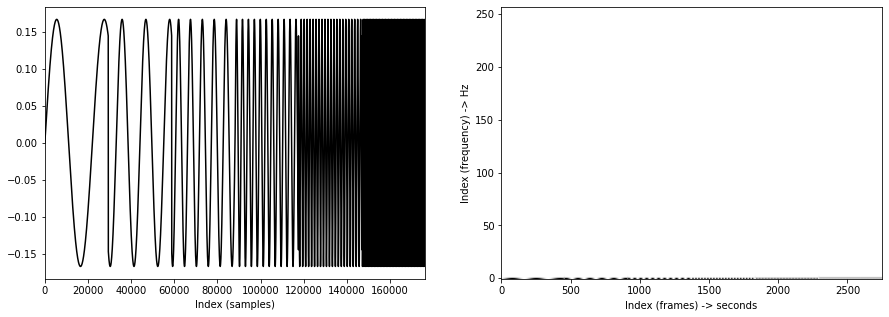

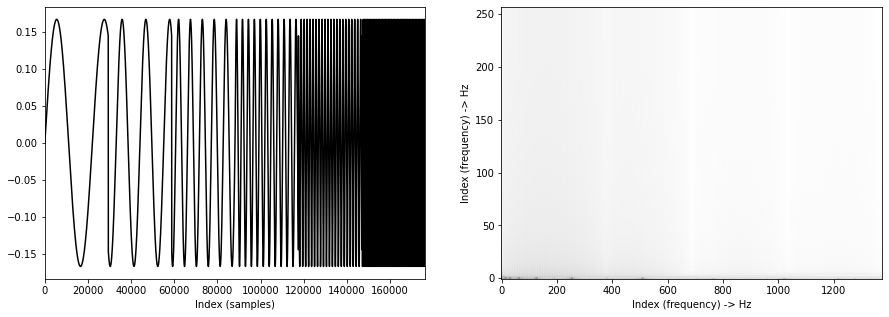

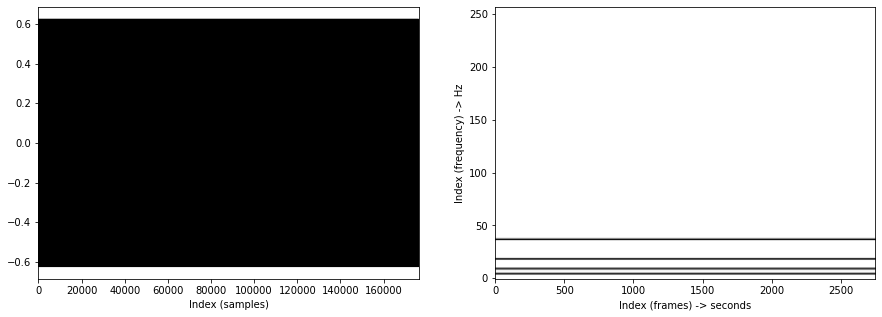

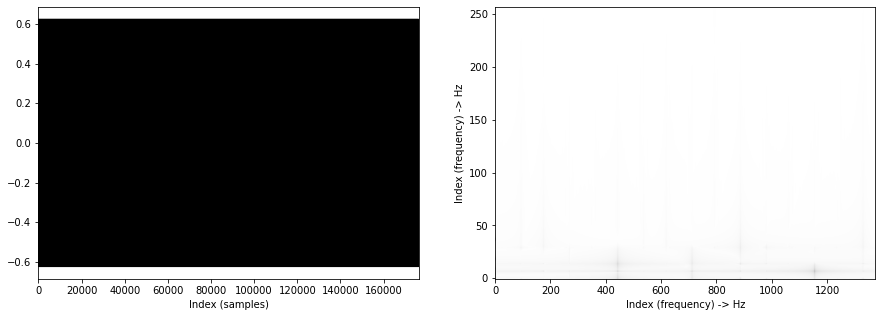

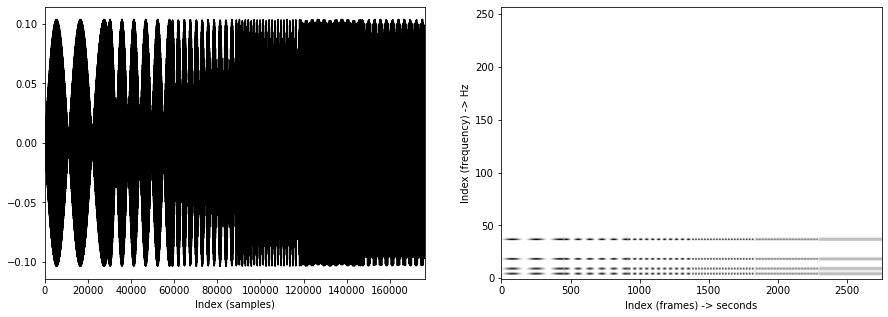

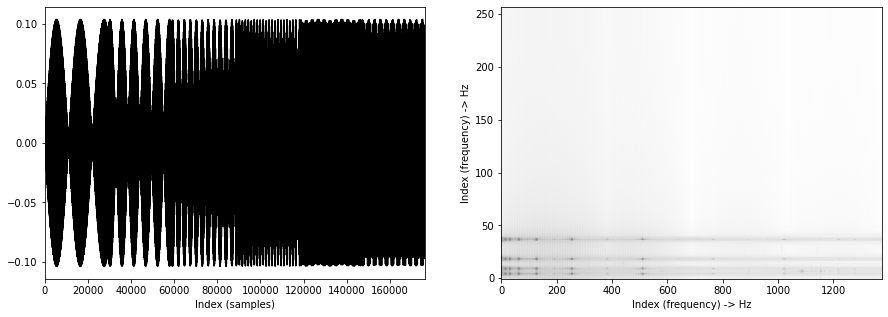

In [99]:
H = 64
N = 512
w = np.hanning(N)

def block_plot(x,t,w,H,only_positive_frequencies=True):
    X, F_coef, T_coef = stft_basic(x, w, Fs, H, only_positive_frequencies)
    ModX, _, Mod_coef = get_mod_specgram(x, w, Fs, H, only_positive_frequencies)
    plot_content(x,t,np.abs(X) ** 2, get_stft_boundaries(F_coef, T_coef, N, Fs))
    plot_content(x,t,np.abs(ModX) ** (1. / 4) , get_mod_boundaries(F_coef, Mod_coef, X[1], Fs), is_mod=True)
    return ModX, X

block_plot(modulator,t,w,H)
block_plot(carrier,t,w,H)
ModSignal, Xsignal = block_plot(signal,t,w,H)

In [100]:
energies_stft = [ np.mean(np.abs(Xsignal[i])) for i in range(Xsignal.shape[0]) ]
row_indexes_stft = [ i for i in range(len(energies_stft)) if energies_stft[i]>np.max(energies_stft)/2 ]
row_indexes_stft

[4, 5, 9, 10, 18, 19, 36, 37, 38]

/opt/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


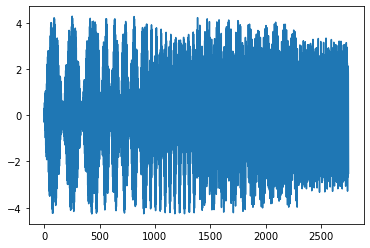

In [101]:
plt.plot(Xsignal[18][:])

/opt/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


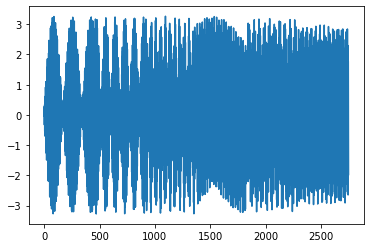

In [102]:
plt.plot(Xsignal[38][:])

In [103]:
energies_mod = [ np.mean(np.abs(ModSignal[i])) for i in range(ModSignal.shape[0]) ]
row_indexes_mod = [ i for i in range(len(energies_mod)) if energies_mod[i]>np.max(energies_mod)/2 ]
row_indexes_mod

[4, 5, 9, 10, 18, 19, 37, 38]

/opt/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


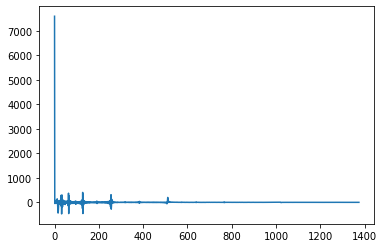

In [104]:
plt.plot(ModSignal[18][:])

/opt/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


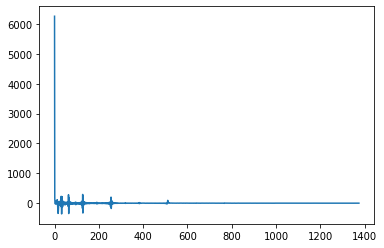

In [105]:
plt.plot(ModSignal[38][:])

/opt/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


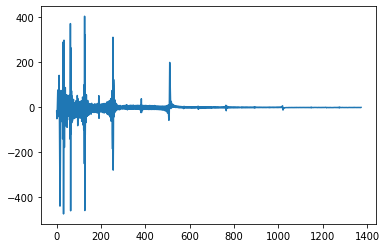

In [106]:
plt.plot(ModSignal[18][1:])

/opt/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


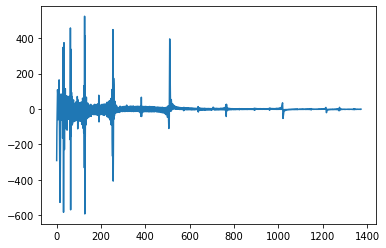

In [107]:
plt.plot(ModSignal[37][1:])

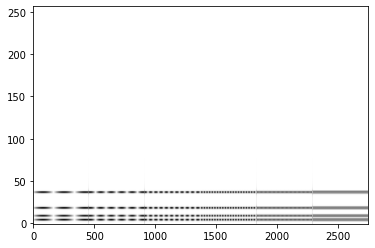

In [108]:
plt.imshow(abs(Xsignal), origin='lower', aspect='auto', cmap='gray_r')

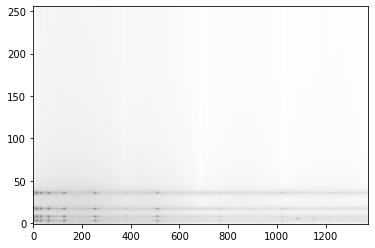

In [109]:
plt.imshow(abs(ModSignal[1:])** (1. / 4), origin='lower', aspect='auto', cmap='gray_r')